## Step counts visuliazations
Note: for all years where device is from apple watch (10/2015 - present)

In [224]:
# load libraries
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from fxns import *
import datetime as dt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go

In [145]:
# load data
df = pd.read_csv("data/steps.csv", parse_dates=True)
df.rename(columns={'value':'stepCount'}, inplace=True) # rename "value"
df = df[['stepCount', 'creationDate']] # relevant values

# use function to convert dates to date values, get days/month/year
check_dates(df)
df['creationDate'] = df['creationDate'].dt.date

# group by date
df = df.groupby('creationDate', as_index=False)['stepCount'].sum()

# parse date info
check_dates(df) # check for dates again after grouping
df['year'] = df['creationDate'].dt.year
df['month_name'] = df['creationDate'].dt.month_name()
df['month'] = df['creationDate'].dt.month
df['day'] = df['creationDate'].dt.day
df['day_name'] = df['creationDate'].dt.day_name()


In [146]:
# check to make sure it looks right
df.sample(n=5)

,creationDate,stepCount,year,month_name,month,day,day_name
48,2015-11-19,6543.0,2015,November,11,19,Thursday
929,2018-05-08,13958.0,2018,May,5,8,Tuesday
1904,2021-01-08,3286.0,2021,January,1,8,Friday
480,2017-02-13,4538.0,2017,February,2,13,Monday
1846,2020-11-11,2033.0,2020,November,11,11,Wednesday


# Visualizations

# Plotly

In [20]:
# for jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

In [46]:
# overall steps
fig = px.line(y=df["stepCount"], x=df["creationDate"])
fig.update_layout(
    title = "Steps Line Chart",
    yaxis_title='Steps',
    xaxis_title='Date',
    xaxis_tickangle=-40,
    font=dict(size=10),
    showlegend=False
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

In [48]:
# steps by day of week
byday = df.groupby("day_name", as_index=False)['stepCount'].sum()
fig = px.bar(byday, 
             x=byday['day_name'], 
             y=byday['stepCount'], 
             color=byday['day_name'], 
#              text=bymonth['month_name'],
             color_continuous_scale='Rainbow',
#              orientation='h',
             labels={'color':''}
            )
fig.update_layout(
    title = "Step Count Per Day of Week",
    xaxis_title='Day',
    yaxis_title='Steps',
    xaxis_tickangle=-40,
    yaxis={'visible': False, 'showticklabels': False},
    showlegend=False,
    font=dict(size=15),
    
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

In [44]:
# monthly breakdown
bymonth = df.groupby("month_name", as_index=False)['stepCount'].sum()
fig = px.bar(bymonth, 
             x=bymonth['month_name'], 
             y=bymonth['stepCount'], 
             color=bymonth['month_name'], 
#              text=bymonth['month_name'],
             color_continuous_scale='Rainbow',
#              orientation='h',
             labels={'color':''}
            )
fig.update_layout(
    title = "Step Count Per Month",
    xaxis_title='Month',
    yaxis_title='Steps',
    xaxis_tickangle=-40,
    yaxis={'visible': False, 'showticklabels': False},
    showlegend=False,
    font=dict(size=15),
    
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

# matplotlib / seaborn

Averages

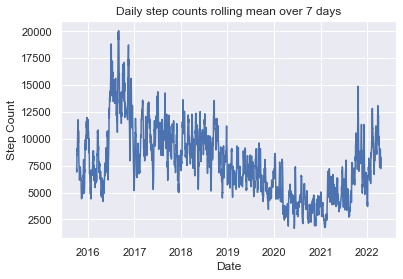

In [282]:
# 7 day rolling average of steps
df['Rolling7DMeanSteps'] = df.stepCount.rolling(window=7, center=True).mean()
fig, ax = plt.subplots()
ax.plot(df['creationDate'], df['Rolling7DMeanSteps'])
ax.set(title = 'Daily step counts rolling mean over 7 days', 
       xlabel='Date',
       ylabel='Step Count')
# plt.figsize=(10, 8)

plt.savefig('output/7day_steps.png')

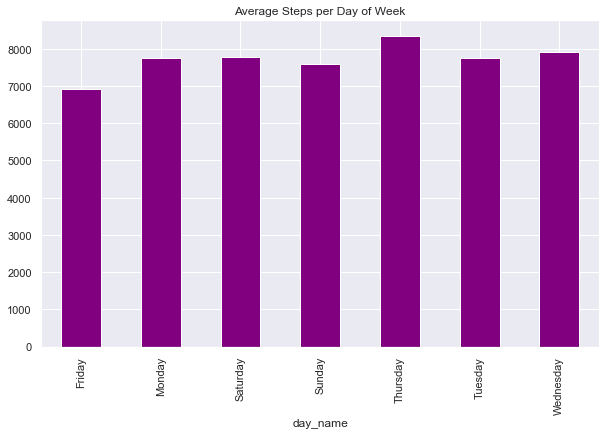

In [290]:
# Average steps per weekday
df.groupby("day_name")['stepCount'].agg('mean').plot.bar(color='purple',title='Average Steps per Day of Week', figsize=(10,6))
plt.savefig('output/avg_steps_weekDay.png')

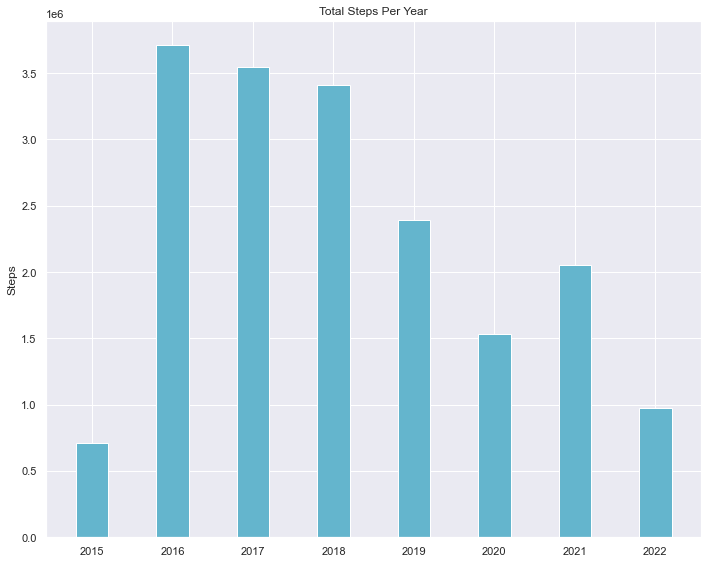

In [300]:
# step count by year
byyear = df.groupby("year", as_index=False)['stepCount'].sum()

fig, ax = plt.subplots(figsize=[10, 8])
ax.yaxis.grid(True)

bar_width = 0.4

fig = plt.bar(byyear.year, byyear.stepCount, bar_width,
                 alpha=1,
                 color='c',
                 label='Steps')


ax.set(ylabel='Steps', title='Total Steps Per Year',
       xticks=byyear.year)
# plt.legend()

plt.tight_layout()
plt.savefig('output/total_stepspyear.png')

<AxesSubplot:xlabel='year', ylabel='month_name'>

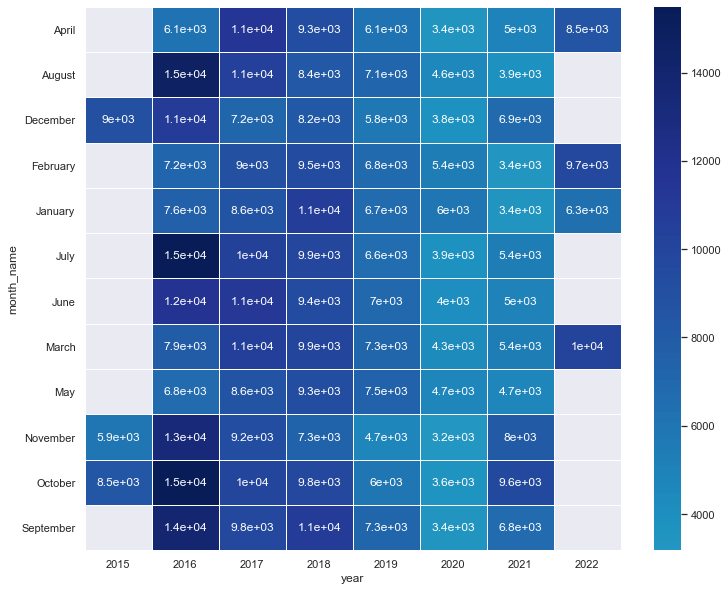

In [299]:
# Make heat map over average steps per day


sns.set_theme()

# Load the example month, date, steps total dataset and convert to long-form
steps_long = df.groupby(['year', 'month_name'], as_index=False)['stepCount'].mean()
steps = steps_long.pivot("month_name", "year", "stepCount")


# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(steps, annot=True, linewidths=.75, ax=ax, center=0, cmap="YlGnBu")

In [236]:
# average steps per month/year
steps_long = df.groupby(['year', 'month_name'], as_index=False)['stepCount'].mean()
steps_long

,year,month_name,stepCount
0,2015,December,9031.838710
1,2015,November,5943.200000
2,2015,October,8455.766667
3,2016,April,6067.137931
4,2016,August,14625.419355
...,...,...,...
74,2021,September,6782.033333
75,2022,April,8499.000000
76,2022,February,9695.785714
77,2022,January,6332.387097


## Analyses (come back to explain later)

In [220]:
# add external variables

# dummy: 1 during covid, pre-vaccine, 0 otherwise/after 2 shots vaccine
df['covid'] = 0
df.loc[((df.year == 2020) & (df.month > 2) | (df.year == 2021) & (df.month > 2)), 'covid'] = 1

# dummy: 1 during holidays, 0 otherwise
df['holidays'] = 0
df.loc[(df.month == 12) | (df.month == 1), 'holidays'] = 1

<Figure size 864x864 with 0 Axes>

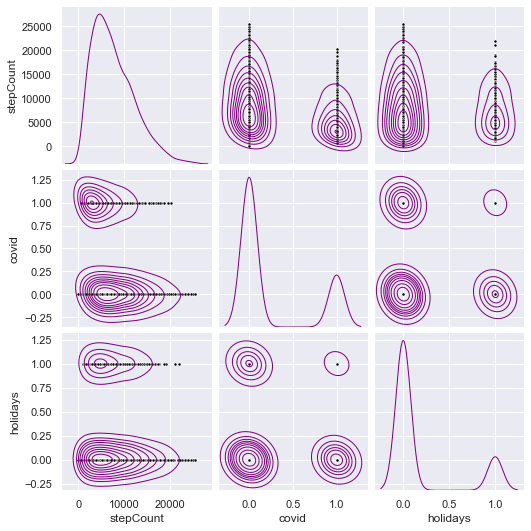

In [221]:
# pairwise plot
fig = plt.figure(figsize=(12, 12)) 

g = sns.pairplot(df[['stepCount', 'covid', 'holidays']], 
             kind='kde',
             plot_kws=dict(fill=False, color='purple', linewidths=1),
             diag_kws=dict(fill=False, color='purple', linewidth=1))

# add observation dots
g.map_offdiag(sns.scatterplot, marker='.', color='black')

<AxesSubplot:>

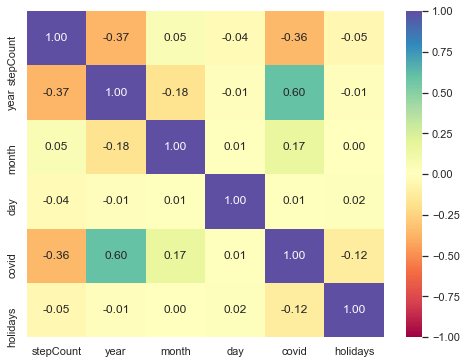

In [222]:
# correlation matrix
cm = df.corr()

# heatmap
fig = plt.figure(figsize=(8,6)) 
sns.heatmap(cm, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

In [223]:
# OLS regression
model = smf.ols('stepCount ~ 1 + year + month + holidays + covid', data=df.dropna())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              stepCount   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     127.1
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           2.10e-98
Time:                        17:35:31   Log-Likelihood:                -23125.
No. Observations:                2374   AIC:                         4.626e+04
Df Residuals:                    2369   BIC:                         4.629e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.037e+06   1.19e+05      8.704      0.000    8.03e+05    1.27e+06
year        -509.5171     58.994     -8.637      0.000    -625.201    -393.833
month         69.8458     25.981      2.688      0.007      18.898     120.794
holidays   -1019.6087    221.381     -4.606      0.000   -1453.729    -585.488
covid      -2575.9835    260.772     -9.878      0.000   -3087.349   -2064.618
==============================================================================
Omnibus:                      235.067   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.164
Skew:                           0.821   Prob(JB):                     2.70e-68
Kurtosis:                       3.669   Cond. No.                     2.84e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""